In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.special import jv
import matplotlib.pyplot as plt
import math
import time
import numpy as np
import matplotlib.pyplot as plt
# Change here

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t
from few.utils.geodesic import get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.interpolate import CubicSpline
from few import get_file_manager
from scipy.integrate import cumulative_trapezoid


In [ ]:

# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1)
frequencies = data[:,0]
psd_values  = data[:, 1] ** 2
# define PSD function
get_sensitivity = CubicSpline(frequencies, psd_values)
f_plots = np.logspace(-5, 0, 600)
#f = freq >= 0.0
#print("f, ASD, PSD:", data[10,0], np.sqrt(get_sensitivity(data[10,0])), get_sensitivity(data[10,0]))


In [ ]:
# Returns nu in Hz (given a in meters)
def nu_naught(a): 
    return (1/(2*np.pi)) * np.sqrt(G*Mtot / a**3)

In [ ]:

# Physical constants - everything is in metric units
G   = 6.67430e-11 # N(m/kg)²
c   = 299792458.0 # m/s
Msun = 1.98847e30 # kg
pc   = 3.085677581491367e16 # Meters
yr   = 365.25*24*3600 # seconds

# System parameters
Mbh = 4e6 * Msun        # central black hole mass (kg)
m   = 0.05 * Msun       # brown dwarf mass (kg)
D   = 8000 * pc         # Distance to GC (m)
Mtot = Mbh + m # Total mass (kg)
mu = (Mbh*m)/Mtot  # Since EMRI, probably can just be equal to m
S_spin = 0.0 # Current Approximation, aka a_star = S/M^2

# Initial orbital parameters
a0 = 0.002 * pc         # semi-major axis (m)
e0 = 0.999             # initial eccentricity (unitless)
gamma_0 = 0.0 # Angle !
nu_0 = nu_naught(a0) # Hz
phi_0 = 0.0 # Angle

M_geo = G * Mbh / c**3   # seconds
m_geo = G * m / c**3     # seconds

y0 = [phi_0, nu_0, gamma_0, e0, a0]

# Plunge radius
plunge_radius = 8*G*Mbh/c**2 

In [ ]:
def g_n_e(n, e):
    ne = n*e
    Jn_2 = jv(n-2, ne)
    Jn_1 = jv(n-1, ne)
    Jn   = jv(n,   ne)
    Jn1  = jv(n+1, ne)
    Jn2  = jv(n+2, ne)
    term1 = Jn_2 - 2*e*Jn_1 + (2.0/n)*Jn + 2*e*Jn1 - Jn2
    term2 = Jn_2 - 2*Jn + Jn2
    return (n**4/32.0) * (term1**2 + (1 - e**2)*term2**2 + (4.0/(3*n**2))*(Jn**2))


In [ ]:

# Peters da/dt and de/dt (use a and e directly)
def da_dt(phi, nu, gamma, e, a):
    one_e2 = np.maximum(1e-16, 1 - e**2)
    e = float(np.minimum(e, 1 - 1e-16))
    a = float(np.maximum(a, plunge_radius)) # if needed
    #one_e2 = 1-e**2
    return -(64/5) * G**3 * m * Mbh * Mtot / (c**5 * a**3 * one_e2**(7/2)) * (1 + (73/24)*e**2 + (37/96)*e**4)

def de_dt(phi, nu, gamma, e, a):
    one_e2 = np.maximum(1e-16, 1 - e**2)
    a = np.maximum(a, plunge_radius)
    e = np.minimum(e, 1 - 1e-16)
    return -(304/15) * e * G**3 * m * Mbh * Mtot / (c**5 * a**4 * one_e2**(5/2)) * (1 + (121/304)*e**2)

def dphi_dt(phi, nu, gamma, e, a):
    return 2*np.pi*nu

def dgamma_dt(phi, nu, gamma, e, a):
    # Asume cos(lambda) = 1
    lambda_var = 0
    a_star = 0.0

    # Avoid division by zero
    zero_term = np.maximum(1e-16, (1-e**2))

    first_term = 6*np.pi*nu * (2*np.pi*nu*M_geo)**(2/3) * (zero_term)**(-1)
    second_term = 1 + (1/4)*(2*np.pi*nu*M_geo)**(2/3) * (zero_term)**(-1) * (26-15*e**2)
    
    # Let spin factor be S/M**2 = 0.0
    third_term = -12*np.pi*nu*np.cos(lambda_var)*(a_star)*(2*np.pi*M_geo*nu)*(zero_term)**(-3/2)
    return (first_term*second_term - third_term)

def dnu_dt(phi, nu, gamma, e, a):    
    lambda_var = 0
    a_star = 0.0
    zero_term = np.maximum(1e-16,(1-e**2))
    first_term = (96/(10*np.pi))*(m_geo/(M_geo**3))*((2*np.pi*M_geo*nu)**(11/3)) * ((zero_term)**(-9/2))
    a1 = 1 + (73/24)*(e**2) + (37/96)*(e**4)
    b1 = (1273/336) - (2561/224)*(e**2) - (3885/128)*(e**4) - (13147/5376)*(e**6)
    c1 = (73/12) + (1211/24)*(e**2) + (3143/96)*(e**4) + (65/64)*(e**6)
    return first_term*(a1*(zero_term) + ((2*np.pi*M_geo*nu)**(2/3))*b1 - ((2*np.pi*M_geo*nu)*(a_star)*np.cos(lambda_var)*((zero_term)**(-1/2)))*c1)

# ODE rh
def rhs(t, y):
    phi, nu, gamma, e, a = y
    dphi = dphi_dt(phi, nu, gamma, e, a)
    dnu = dnu_dt(phi, nu, gamma, e, a)
    dgamma = dgamma_dt(phi, nu, gamma, e, a)
    decc = de_dt(phi, nu, gamma, e, a)
    da = da_dt(phi, nu, gamma, e, a)
    
    return [dphi, dnu, dgamma, decc, da]
    

In [ ]:
# Plunge event
def stop_plunge(t, y):
    phi, nu, gamma, e, a = y
    return a*(1 - e) - plunge_radius
stop_plunge.terminal = True
stop_plunge.direction = -1

In [ ]:
# Integrate
t_initial = 1e15 # 3.17 x 10^7 years but integrate from "now aka zero" until "then"

sol = solve_ivp(rhs, [0, t_initial], y0, method='Radau', events=stop_plunge,
                rtol=1e-9, atol=1e-12, max_step=1e11)
if sol.status == 1 and len(sol.t_events[0])>0:
    print("Plunge event at t =", sol.t_events[0][0], "s")
t_arr = sol.t
#time_to_plunge = abs((t_arr[-1] - t_arr) / yr)
phi_arr = sol.y[0]
nu_arr = sol.y[1]   # e is second
gamma_arr = sol.y[2]
e_arr = sol.y[3]
a_arr = sol.y[4]


Plunge event at t = 221654128462847.9 s


In [ ]:
time_to_plunge = abs(((t_arr[-1] - t_arr) / yr))

In [ ]:
a_arr_pc = a_arr/pc

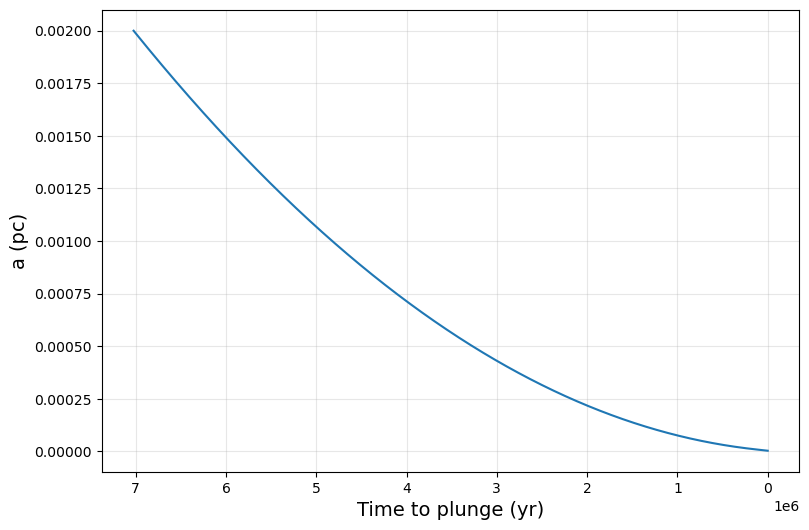

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, a_arr_pc)
plt.xlabel("Time to plunge (yr)",fontsize=14)
plt.ylabel("a (pc)",fontsize=14)
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)

plt.gca().invert_xaxis()
plt.show()

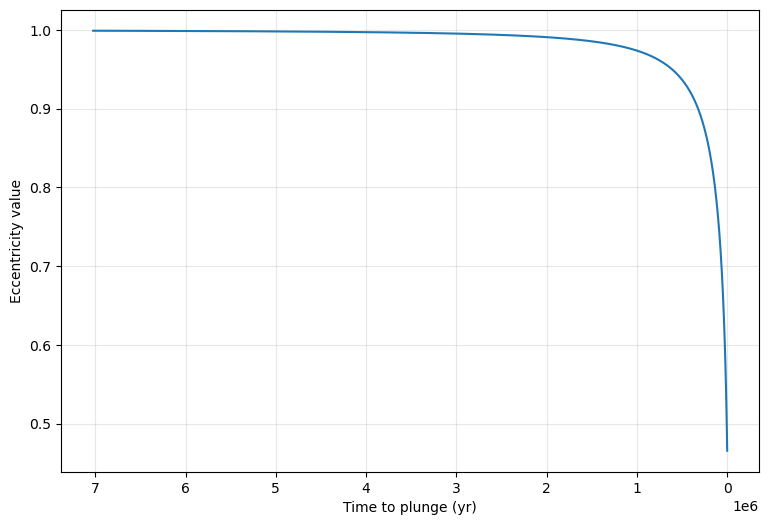

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, e_arr)
plt.xlabel("Time to plunge (yr)")
plt.ylabel("Eccentricity value")
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

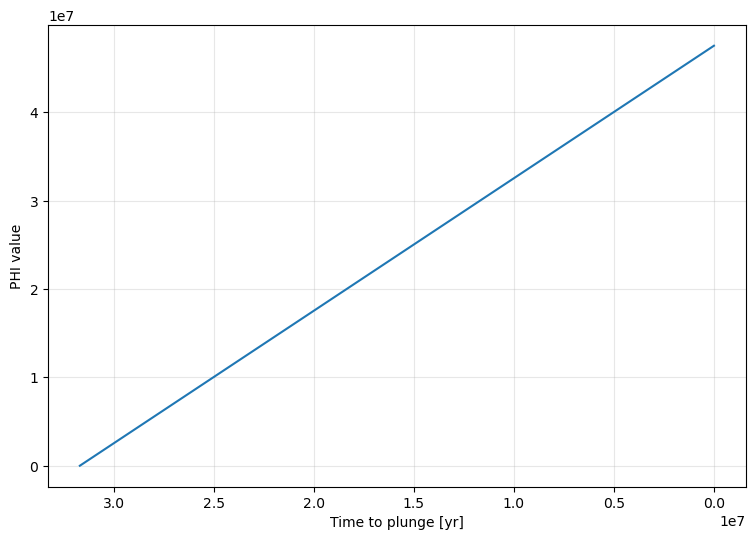

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, phi_arr)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("PHI value")
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

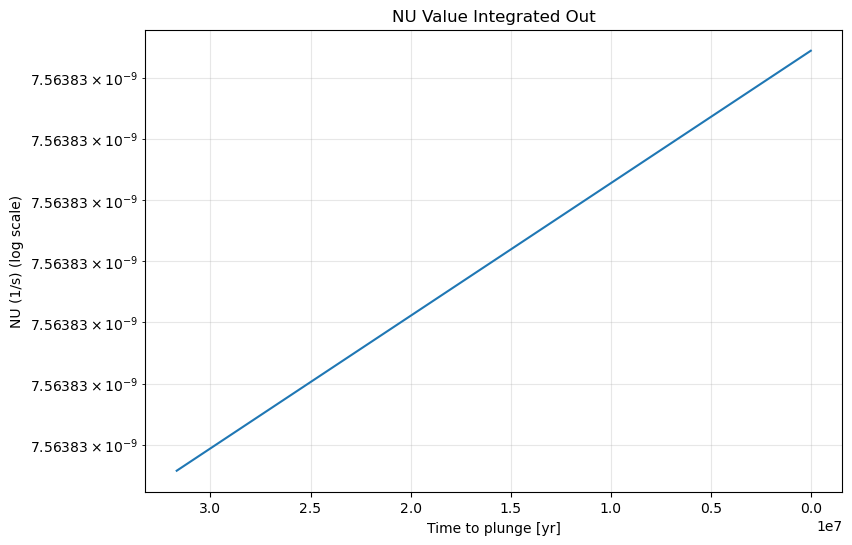

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, nu_arr)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("NU (1/s) (log scale)")
plt.title("NU Value Integrated Out")
plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
nu_arr_2 = nu_naught(a_arr)

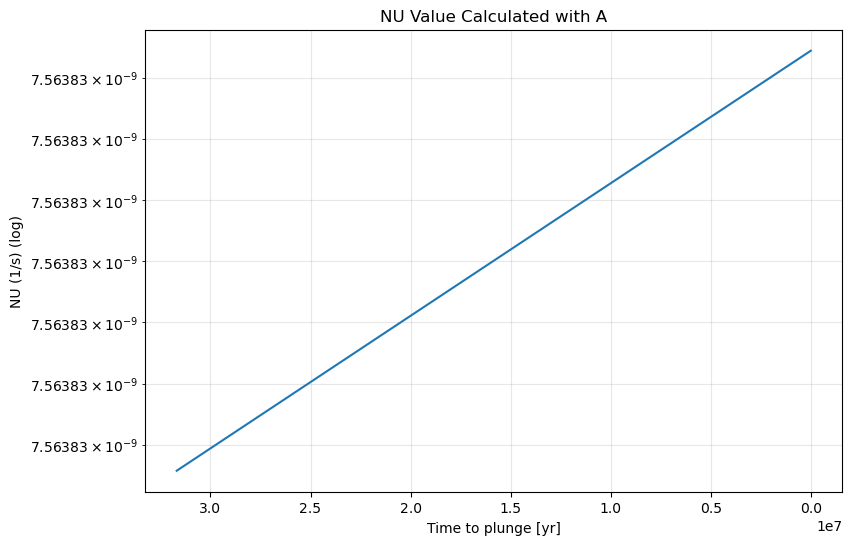

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, nu_arr_2)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("NU (1/s) (log)")
plt.title("NU Value Calculated with A")
plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
dgamma_dt_2 = np.gradient(gamma_arr, t_arr)

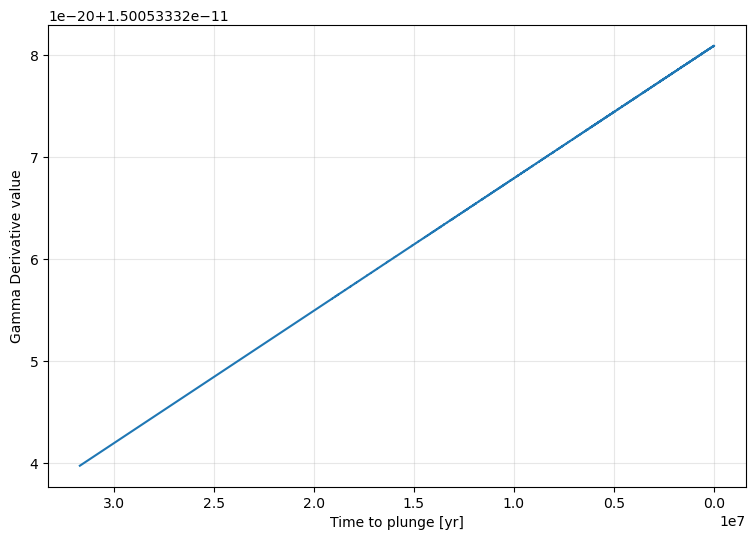

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, dgamma_dt_2)
plt.xlabel("Time to plunge [yr]")
plt.ylabel("Gamma Derivative value")
#plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

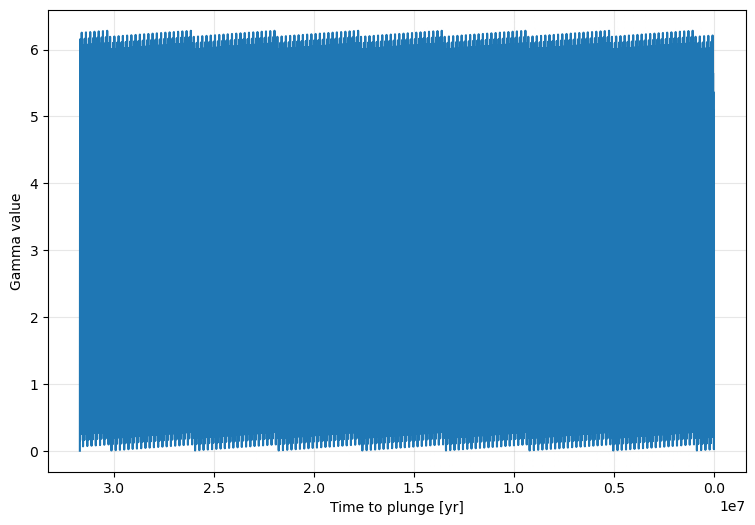

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(time_to_plunge, np.mod(gamma_arr,2*np.pi))
plt.xlabel("Time to plunge [yr]")
plt.ylabel("Gamma value")
#plt.yscale('log')
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

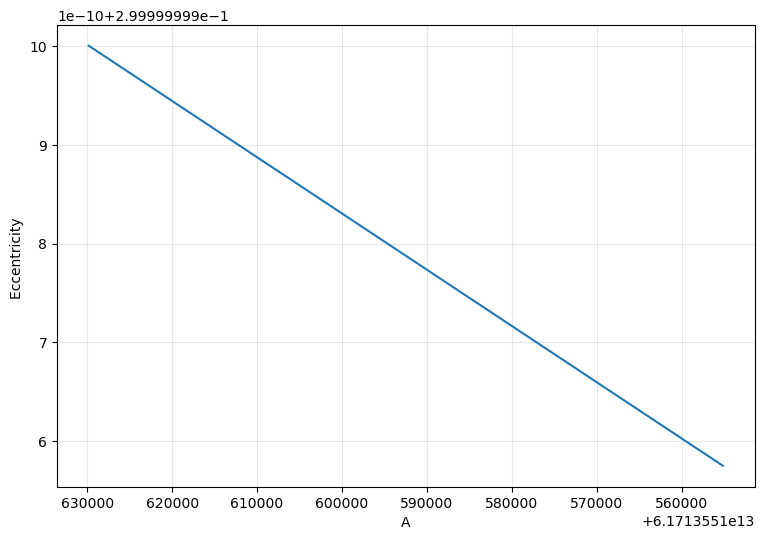

In [ ]:
plt.figure(figsize=(9,6))
plt.plot(a_arr, e_arr)
plt.xlabel("A")
plt.ylabel("Eccentricity ")
plt.grid(True, which='both', alpha=0.3)
plt.gca().invert_xaxis()
plt.show()

In [ ]:
# Orbital frequency
def nu_naught(a): # Returns Hz, given a in meters
    return (1/(2*np.pi)) * np.sqrt(G*Mtot / a**3)

def orbital_frequency(nu, gamma, n, dgamma_dt): # Returns Hz
    f_ = n*nu + dgamma_dt/np.pi
    return f_

def derivE(n, a, e, nu, gamma):#, dgamma_dt):
    dgamma_dt = np.gradient(gamma_arr, t_arr)
    #nu = orbital_frequency(nu, gamma, n, dgamma_dt)
    return g_n_e(n, e)*(32.0/5.0)*mu**2 * (G*Mtot)**(4.0/3.0) * (2*np.pi*nu)**(10.0/3.0)

def derivF(n, a, e, nu, gamma, t_arr):
    pre = -3/(4*np.pi)
    sqrt = (np.sqrt((a**3)/G*Mtot))/(a)
    #da = da_dt(a, e)
    da = np.gradient(a, t_arr)
    return pre*sqrt*da

def h_n_deriv(n, a, e):
    E_dot = derivE(n, a, e)
    f_dot = derivF(n, a, e)
    h_n = np.sqrt(2*E_dot/f_dot)/(np.pi*D)
    return h_n

In [ ]:
def Sn_lisa(f):
    f = np.array(f, dtype=float)
    f[f <= 1e-12] = 1e-12
    S_inst = (9.18*10**(-52)/(f**4)) + (1.59*(10**(-41))) + (9.18*(10**(-38)*(f**2)))
    S_ex_gal = 4.2*(10**(-47))*(f**(-7/3))
    dN = 2*(10**(-3))*((1/f)**(11/3))
    S_gal = 2.1*(10**(-45))*((f)**(-7/3))
    S_inst_gal = np.minimum(S_inst/math.exp(-1.5/yr)*dN, S_inst + S_gal)
    return S_inst_gal + S_ex_gal

In [ ]:
S = Sn_lisa(f_plots)
S2 = Sn_lisa(frequencies)

In [ ]:
def SN_FEW(f):
    return get_sensitivity(f)


In [ ]:
S_FEW = SN_FEW(f_plots)
S_FEW2 = SN_FEW(frequencies)

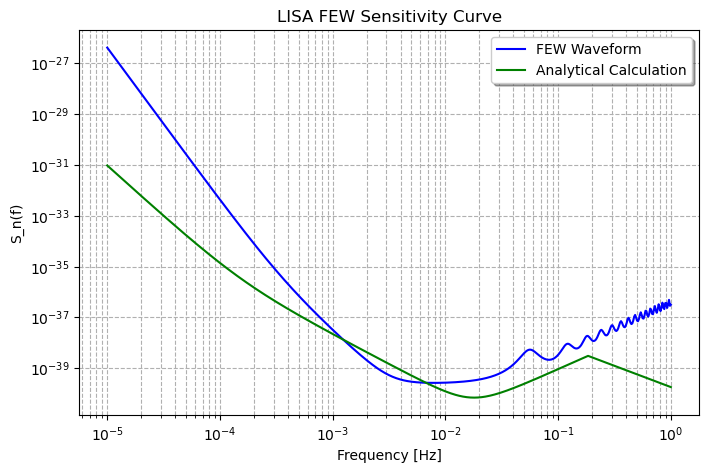

In [ ]:
plt.figure(figsize=(8,5))
plt.loglog(frequencies, S_FEW2, color = 'blue', label = 'FEW Waveform')
plt.loglog(frequencies, S2, color = 'green', label = 'Analytical Calculation')
plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True) 
plt.xlabel('Frequency [Hz]')
plt.ylabel('S_n(f)')
plt.title('LISA FEW Sensitivity Curve')
plt.grid(True, which='both', ls='--')
plt.show()

In [ ]:
# Orbital Frequency vs Eccentricity
f_orbital =  []
dgamma_dt_plt = np.gradient(gamma_arr, t_arr)
for i in range(11):
    f_orbital.append(orbital_frequency(nu_arr_2, gamma_arr, i+1, dgamma_dt_plt))



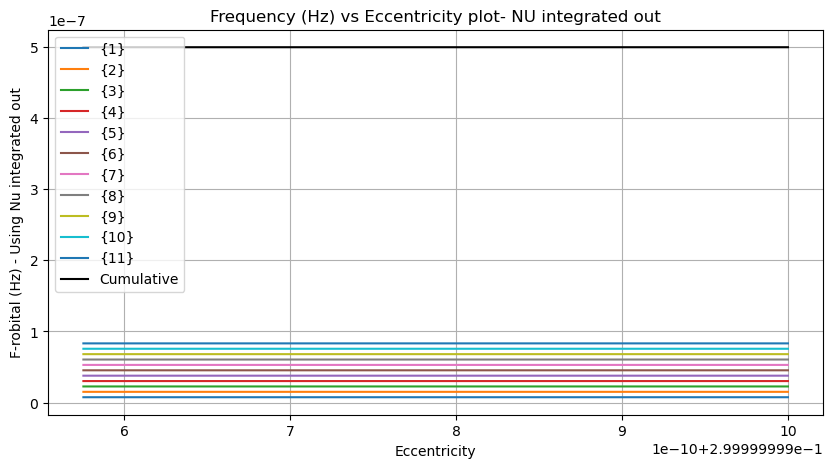

In [ ]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot(e_arr, f_orbital[i], label={i+1})
plt.plot(e_arr, np.sum(f_orbital[:11], axis=0), label="Cumulative", color = 'black')
plt.xlabel("Eccentricity")
plt.ylabel("F-robital (Hz) - Using Nu integrated out")
#plt.yscale('log')
plt.title("Frequency (Hz) vs Eccentricity plot- NU integrated out")
plt.legend()
#plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

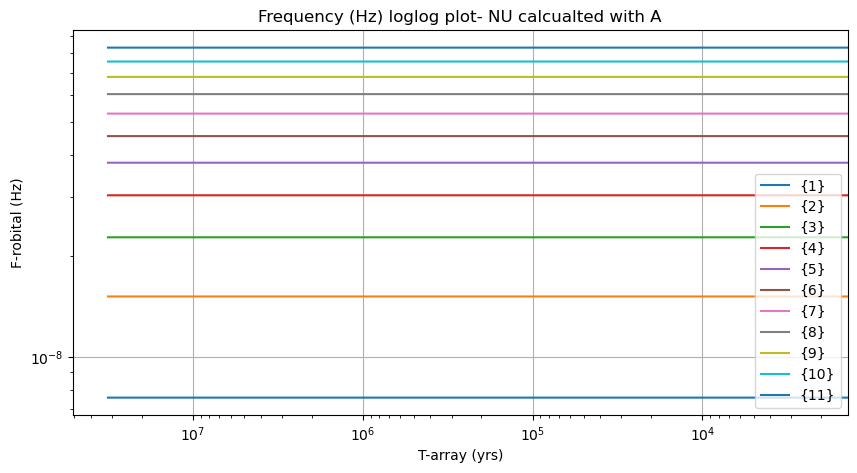

In [ ]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.loglog(time_to_plunge, f_orbital[i], label={i+1})
plt.xlabel("T-array (yrs)")
plt.ylabel("F-robital (Hz)")
plt.title("Frequency (Hz) loglog plot- NU calcualted with A")
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [ ]:
# Given a in meters, G in m^3 kg^-1 s^-2, mass in kg, c in m/s, D in meters this returns unitless !!
def h_c_n(n, a, e): 
    return g_n_e(n, e)*G**2 * Mbh* m / (D * a * c**4)

In [ ]:
h_c_n_arr = []
for i in range(11):
    h_c_n_arr.append(h_c_n(i+1, a_arr, e_arr))

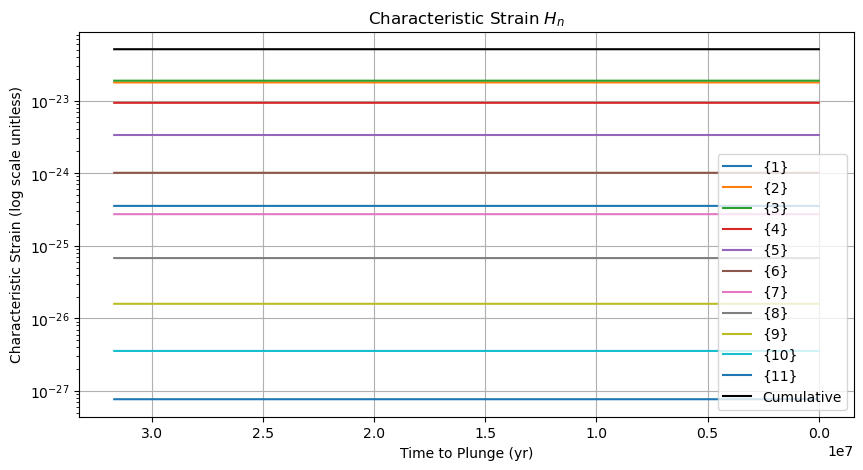

In [ ]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.plot(time_to_plunge, h_c_n_arr[i], label={i+1})
plt.plot(time_to_plunge, np.sum(h_c_n_arr[:11], axis=0), label="Cumulative", color = 'black')
plt.yscale('log')
plt.xlabel("Time to Plunge (yr)")
plt.ylabel("Characteristic Strain (log scale unitless)")
plt.gca().invert_xaxis()
plt.title("Characteristic Strain $H_n$")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
n_harmonics = 10

In [ ]:
snr_of_n_of_t = np.full((n_harmonics + 1, len(t_arr)), np.nan)

In [ ]:
for n in range(1, 11):
    for i, t0 in enumerate(t_arr):
        mask = (t_arr >= t0) & (t_arr <= t0 + yr)
        if np.sum(mask) < 2:   # skip windows with fewer than 2 points
            continue
        t_0_arr = t_arr[mask]
        a_0_arr = a_arr[mask]
        e_0_arr = e_arr[mask]
        gamma_0_arr = gamma_arr[mask]
        #nu_0_arr = nu_arr[mask]
        nu_0_arr = nu_arr_2[mask]
        phi_0_arr = phi_arr[mask]
        dgamma_dt = np.gradient(gamma_0_arr, t_0_arr)
        
        f_n = orbital_frequency(nu_0_arr,gamma_0_arr, n, dgamma_dt)
        #f_n = n*forb
        
        #dt = t_arr[1] - t_arr[0]   # assumes uniform spacing
        #dfdt = np.gradient(f_n, t_0_arr)
       
        hcn = h_c_n(n, a_0_arr, e_0_arr)
        h_det = np.sqrt(SN_FEW(f_n))
        integrand = (hcn/h_det)**2 /(f_n)
        snr_of_n_of_t[n,i] = np.trapz(integrand, np.log(f_n))
        #print(np.min(f_n), np.max(f_n))
        if np.any(f_n <= 0):
            print(f"t0 = {t0}, f_n min/max: {np.min(f_n)}, {np.max(f_n)}")
        continue
        if np.any(h_det <= 0):
            print(f"t0 = {t0}, h_det has zeros")
        continue

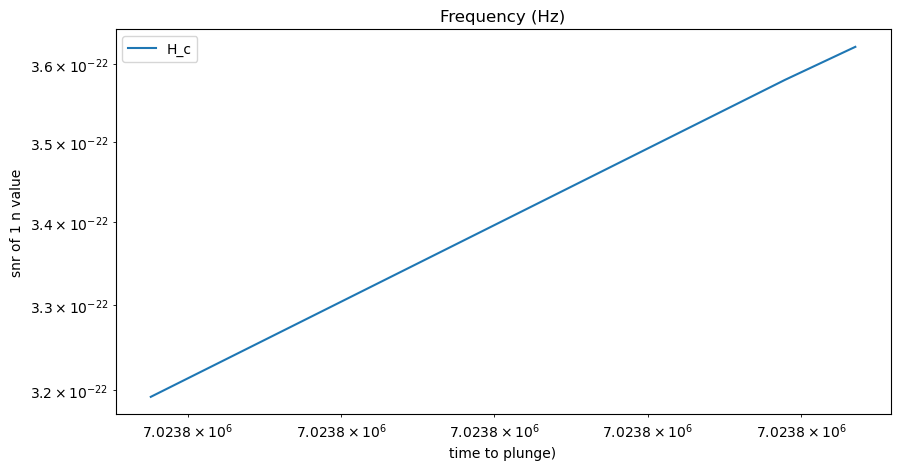

In [ ]:
plt.figure(figsize=(10,5))
plt.loglog(time_to_plunge, snr_of_n_of_t[2,:], label="H_c")
plt.xlabel("time to plunge)")
plt.ylabel("snr of 1 n value")
plt.title("Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def h_c_n_EVALS(n, a_arr, e_arr, nu_arr, gamma_arr, dgamma_dt, t_arr):
    return np.sqrt(2*derivE(n, a_arr, e_arr, nu_arr, gamma_arr, dgamma_dt)/derivF(n, a_arr, e_arr, nu_arr, gamma_arr, t_arr))/(np.pi*D)

In [ ]:
h_c_plot_array = []

In [ ]:
h_c_plot = 0

for n in range(11):
    h_c_plot_array.append(np.sqrt(2*derivE(n+1, a_arr, e_arr, nu_arr_2, gamma_arr)/derivF(n+1, a_arr, e_arr, nu_arr_2, gamma_arr, t_arr))/(np.pi*D))
f_plot_h_c = np.logspace(-6, 0, len(t_arr))

/var/folders/ky/qx428sts4cd3wyl0fs1lr6340000gn/T/ipykernel_84691/2075692836.py:4: RuntimeWarning: divide by zero encountered in divide
  h_c_plot_array.append(np.sqrt(2*derivE(n+1, a_arr, e_arr, nu_arr_2, gamma_arr)/derivF(n+1, a_arr, e_arr, nu_arr_2, gamma_arr, t_arr))/(np.pi*D))
/var/folders/ky/qx428sts4cd3wyl0fs1lr6340000gn/T/ipykernel_84691/2075692836.py:4: RuntimeWarning: invalid value encountered in sqrt
  h_c_plot_array.append(np.sqrt(2*derivE(n+1, a_arr, e_arr, nu_arr_2, gamma_arr)/derivF(n+1, a_arr, e_arr, nu_arr_2, gamma_arr, t_arr))/(np.pi*D))


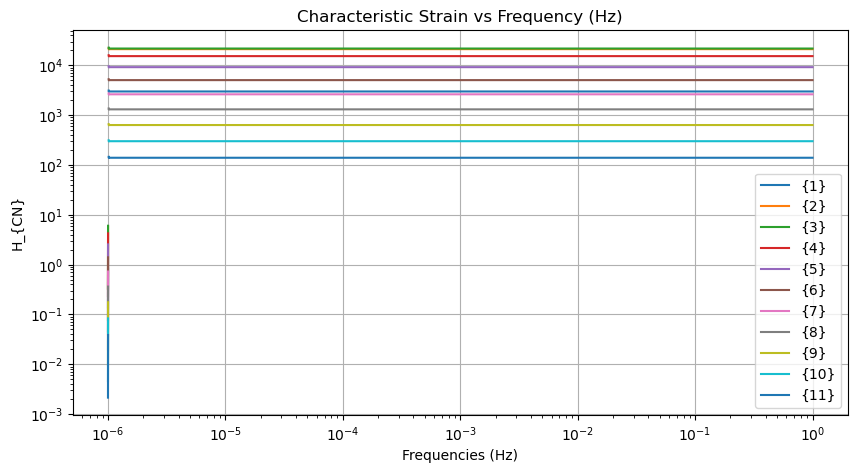

In [ ]:
plt.figure(figsize=(10,5))
for i in range(11):
    plt.loglog(f_plot_h_c,h_c_plot_array[i], label={i+1})
plt.xlabel("Frequencies (Hz)")
plt.ylabel("H_{CN}")
plt.title("Characteristic Strain vs Frequency (Hz)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
snr_squared = np.sum(snr_of_n_of_t[1:], axis=0)

In [ ]:
snr_total = np.sqrt(np.sum(snr_of_n_of_t[1:], axis=0))

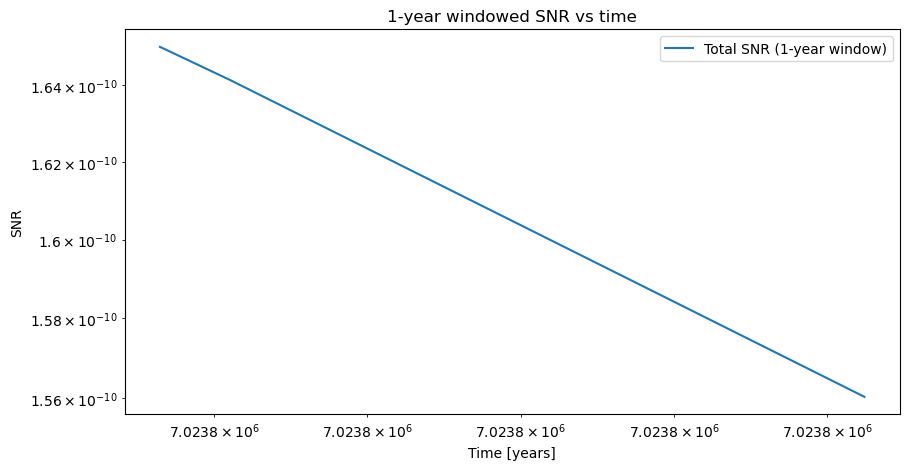

In [ ]:
plt.figure(figsize=(10,5))
plt.loglog(time_to_plunge, snr_total, label="Total SNR (1-year window)")
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel("Time [years]")
plt.ylabel("SNR")
plt.title("1-year windowed SNR vs time")
plt.legend()
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

(2286,)
(2286,)


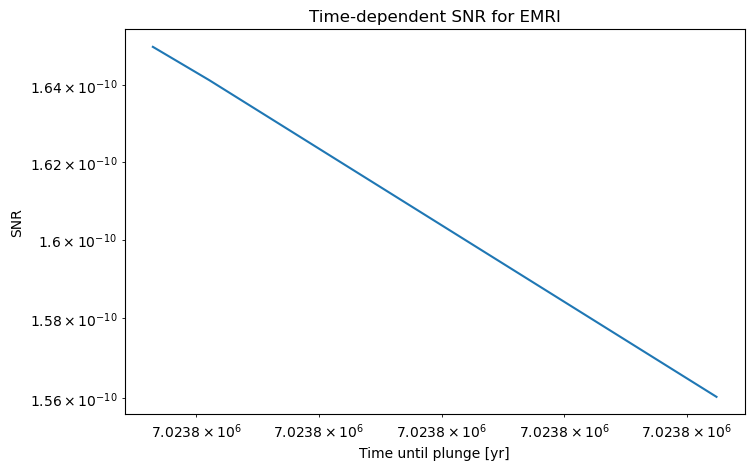

In [ ]:
print(time_to_plunge.shape)
print(snr_total.shape)

# Plot
plt.figure(figsize=(8,5))
plt.loglog(time_to_plunge, snr_total)

plt.xlabel("Time until plunge [yr]")
plt.ylabel("SNR")
plt.title("Time-dependent SNR for EMRI")
plt.grid(True)
plt.gca().invert_xaxis()
plt.show()

#### 